### Evolution stratagy for breakout
https://arxiv.org/pdf/1703.03864.pdf

In [7]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gym

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.optim as optim
from torch.autograd import Variable

import breakout
from imp import reload
reload(breakout)

import copy
import datetime

import json
import pickle

import time

import sys
import multiprocessing as mp

from collections import defaultdict

In [8]:
class dotdict(defaultdict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = defaultdict.get
    __setattr__ = defaultdict.__setitem__
    __delattr__ = defaultdict.__delitem__

In [9]:
def GetNRandomInts(n, min_int=0, max_int=int(1e7)):
    return list(obj for obj in map(int, np.random.randint(min_int, max_int, size=(n, ))))

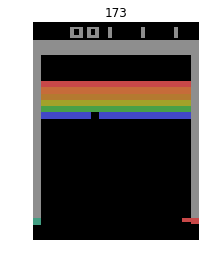

2


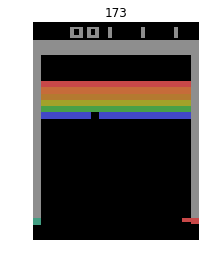

In [10]:
#Screens count visualisation
reload(breakout)
env = gym.make('BreakoutDeterministic-v4')
breakout_vis = breakout.Breakout('BreakoutDeterministic-v4')
reward, done = breakout_vis.MakeStep(1)
for num in range(10000):
    #reward, done = breakout_vis.MakeStep(0)
    action = int(np.random.randint(0, 4))
    print(action)
    reward, done = breakout_vis.MakeStep(action)
    time.sleep(0.2)
    if done:
        break
    breakout_vis.ShowState(title=str(num))

In [11]:
#Cuda support

CUDA = True
def ToTensor(arr):
    if CUDA:
        return torch.Tensor(arr).cuda()
    else:
        return torch.Tensor(arr)

In [12]:
# Virtual batch normalization - аналог батч нормализации, когда средние активации считаются в заранее выбранном батче,
# а потом применяются ко всем остальным
# У нас батч - это последовательность из картинок для одного цикла игр
class VirtualBatchNorm(nn.Module):
    def __init__(self, features_shape, eps=1e-5):
        super().__init__()
        #y = gamma*x_norm + beta
        self.features_shape = features_shape
        self.gamma = nn.Parameter(ToTensor(np.random.normal(1, 0.1, features_shape)))
        self.beta = nn.Parameter(ToTensor(np.random.normal(0, 0.1, features_shape)))
        
        self.clear_norm_parameters()
        self.eps = eps
        
        #Batch for which we are changing weights
        self.is_ref_batch = False
        
    def clear_norm_parameters(self):
        self.mu = ToTensor(np.zeros(self.features_shape))
        self.sigma_sq = ToTensor(np.zeros(self.features_shape))
        self.ref_batch_len = 0
        
    def forward(self, x):
        if self.is_ref_batch:
            x_sum = self.mu * self.ref_batch_len
            x_sq_sum = self.sigma_sq*self.ref_batch_len + 2*self.mu*x_sum - self.mu*self.mu
            x_sum += torch.sum(x.data, dim=0)
            x_sq_sum += torch.sum(x.data * x.data, dim=0)
            
            self.ref_batch_len += 1
            self.mu = x_sum / self.ref_batch_len
            self.sigma_sq = (x_sq_sum - 2*self.mu*x_sum + self.ref_batch_len*self.mu*self.mu) / self.ref_batch_len
        
        x_centred = (x.data - self.mu) / torch.sqrt(self.sigma_sq + self.eps)
        #print(x_centred)
        return Variable(x_centred * self.gamma.data + self.beta.data, requires_grad=False)

def HasModelVBN(model):
    for module in model.modules():
        if type(module) == VirtualBatchNorm:
            return True
    return False

def ApplyVBN(model, breakout, seed, vbn_ref_size=50, max_screens=1000):
    def _ChangeRefBatchState(state):
        for module in model.modules():
            if type(module) == VirtualBatchNorm:
                module.is_ref_batch = state
                if state == True:
                    module.clear_norm_parameters()
                    
    np.random.seed(seed)
    vbn_seeds = GetNRandomInts(vbn_ref_size)
    _ChangeRefBatchState(True)
    for vbn_ref_id in range(vbn_ref_size):
        breakout.GetSummaryScore(model, vbn_seeds[vbn_ref_id], max_screens=max_screens)
    _ChangeRefBatchState(False)

In [18]:
#Works with VirtualBatchNorm layers
class EvolutionStratagy:
    def __init__(self, model,
                 game='BreakoutDeterministic-v4', seed=777,
                 mutation_power=0.02, vbn_ref_size=10, vbn_incr_period=10, population_size=50, population_incr_period=50,
                 learning_rate=0.05, epochs_count=1e4, lr_decr_coeff=0.95, lr_decr_period=100,
                 start_epoch=0, elapsed_times=[], avg_rewards=[], test_rewards=[],
                 filename_base='model_breakout-determ_es_'):
        self.model = model
        self.parameters = [p for p in model.parameters()]
        self.config = dotdict()
        
        self.config['game'] = game
        self.config['seed'] = seed
        
        self.config['mutation_power'] = mutation_power
        self.config['population_size'] = population_size
        self.config['population_incr_period'] = population_incr_period
        self.config['vbn_ref_size'] = vbn_ref_size
        self.config['vbn_incr_period'] = vbn_incr_period
        
        self.config['learning_rate'] = learning_rate
        self.config['epochs_count'] = int(epochs_count)
        self.config['lr_decr_coeff'] = lr_decr_coeff
        self.config['lr_decr_period'] = lr_decr_period
        
        self.config['start_epoch'] = int(start_epoch)
        self.config['elapsed_times'] = elapsed_times
        self.config['avg_rewards'] = avg_rewards
        self.config['test_rewards'] = test_rewards
        
        self.config['filename_base'] = filename_base
        
        self.breakout = breakout.Breakout(game=game, cuda=CUDA)
        self.has_vbn = HasModelVBN(self.model)
        
    #Статическая функция, позволяет загрузить параметры
    def Load(model, name_model, name_json, new_filename_base=None):
        with open(name_model, 'rb') as file:
            state_dict = pickle.load(file)
            model.load_state_dict(state_dict)
        with open(name_json) as file:
            training_state = json.load(file)
        
        if not new_filename_base is None:
            training_state.filename_base = new_filename_base
        
        return EvolutionStratagy(model, **training_state)
    
    def Save(self, epoch):
        with open('models/'+self.config.filename_base+str(epoch)+'.dat', 'wb') as file:
            pickle.dump(self.model.state_dict(), file)
        with open('models/params_'+self.config.filename_base+str(epoch)+'.json', 'w') as file:
            json.dump(self.config, file)
    
    #Получает параметры сети
    def _GetSourceParameters(self):
        source_parameters = []
        for p in self.parameters:
            source_parameters.append(p.data.clone())
        return source_parameters
    
    #Изменяет сеть, предварительно восстановив параметры
    def _MutateParams(self, source_parameters, mutation_vector):
        for pos, p in enumerate(self.parameters):
            p.data = source_parameters[pos].clone()
            p.data += mutation_vector[pos]
        
    #creator - функция, которая принимает размер тензора и генерирует ndarray нужной формы
    def _CreateTensorForEachParameter(self, creator):
        result = []
        for p in self.parameters:
            result.append(ToTensor(creator(p.data.shape)))
        return result
        
    def TrainEpoch(self, epoch_seed, max_screens, vbn_ref_size, population_size, learning_rate):
        np.random.seed(epoch_seed)
        population_seeds = GetNRandomInts(population_size)
        
        if self.has_vbn:
            ApplyVBN(self.model, self.breakout, self.config.seed, vbn_ref_size, max_screens)
            
        source_parameters = self._GetSourceParameters() #Сохраняем параметры сети перед мутациями
              
        #Calculate shift
        #cumulative_mutation - накопленные мутации с учетом reward
        cumulative_mutation = self._CreateTensorForEachParameter(lambda shape: np.zeros(shape))
        avg_reward = 0
        for curr_id in range(population_size):
            #Мутируем каждый элемент популяции
            mutations_vector = self._CreateTensorForEachParameter \
                                    (lambda shape: np.random.normal(0, self.config.mutation_power, shape))
            self._MutateParams(source_parameters, mutations_vector)
            reward = self.breakout.GetSummaryScore(self.model, population_seeds[curr_id], max_screens=max_screens)
            avg_reward += reward
            
            for param_id, mut in enumerate(cumulative_mutation):
                mut += reward * mutations_vector[param_id]
        avg_reward /= population_size
        
        #Shift
        for param_mutation in cumulative_mutation:
            param_mutation /= population_size
            param_mutation /= self.config.mutation_power
            param_mutation *= learning_rate
        self._MutateParams(source_parameters, cumulative_mutation)
        return avg_reward
        
    #Обучает Evolution stratagy. need_graphs=True => каждую эпоху будет производится контрольная игра и ее reward
    #будет отмечен на графике (сохранение в файл - всегда). Для контрольной игры устанавливается seed
    def Train(self, need_graphs=True):
        if self.config.start_epoch != 0:
            epochs_nums = [i for i in range(self.config.start_epoch+1)]
            self.config.start_epoch += 1
        else:
            epochs_nums = []

        np.random.seed(self.config.seed)
        epoch_seeds = GetNRandomInts(self.config.epochs_count)
        for current_epoch in range(self.config.start_epoch, self.config.epochs_count):
            epoch_start_time = datetime.datetime.now()
            self.config.avg_rewards.append(self.TrainEpoch \
                    (epoch_seeds[current_epoch],
                     current_epoch * 3 + 100, #max_screens
                     self.config.vbn_ref_size + (current_epoch // self.config.vbn_incr_period), #vbn_ref_size
                     self.config.population_size + (current_epoch // self.config.population_incr_period), #vbn_ref_size
                     self.config.learning_rate * (self.config.lr_decr_coeff ** (current_epoch // self.config.lr_decr_period))))
            if len(self.config.elapsed_times) == 0:
                self.config.elapsed_times.append((datetime.datetime.now() - epoch_start_time).seconds)
            else:
                self.config.elapsed_times.append(self.config.elapsed_times[-1] + \
                                                 (datetime.datetime.now() - epoch_start_time).seconds)
             
            epochs_nums.append(current_epoch)
            self.config.test_rewards.append(self.breakout.GetSummaryScore(self.model, self.config.seed, current_epoch + 100))
            with open('models/dynamic_'+self.config.filename_base+'.txt', 'w') as file:
                file.writelines(["{0}\t{1}\t{2}\t{3}\n".format(epochs_nums[i], self.config.elapsed_times[i], 
                                                               self.config.avg_rewards[i], self.config.test_rewards[i]) \
                                 for i in range(len(epochs_nums))])
                file.write('=== NEXT EPOCH ===\n')
            if need_graphs:
                plt.clf()
                plt.plot(epochs_nums, self.config.test_rewards)
                plt.plot(epochs_nums, self.config.avg_rewards)
                display.clear_output(wait=True)
                display.display(plt.gcf())
            sys.stdout.write('\rEpoch {0}; Time = {1}; avg_rewards = {2}; Current test reward = {3}'. \
                                     format(current_epoch, self.config.elapsed_times[-1], self.config.avg_rewards[-1], 
                                            self.config.test_rewards[-1]))
            
            self.config.start_epoch = current_epoch
            if (current_epoch % 50 == 0 and current_epoch != 0) or current_epoch == 1:
                self.Save(current_epoch)

In [19]:
#Служебные слои
class VerboseLayer(nn.Module):
    def forward(self, x):
        #print(x.data.shape)
        print(x)
        #print(np.std(x.data.cpu().numpy()))
        return x
    
class RavelLevel(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [20]:
#Возвращает conv2d-слой, инициализированный по HE
def InitLayer(layer_type, *args, **kwargs):
    new_layer = layer_type(*args, **kwargs)
    nn_init.normal(new_layer.weight.data, std=0.01)
    return new_layer

def CreateNewNetwork():
    network = nn.Sequential(InitLayer(nn.Conv2d, 3, 16, kernel_size=8, stride=4), nn.ReLU(),  # #VirtualBatchNorm((16, 51, 39)), 
                            InitLayer(nn.Conv2d, 16, 32, kernel_size=4, stride=2), nn.ReLU(), #VerboseLayer(),#VirtualBatchNorm((32, 24, 18)),
                            RavelLevel(),
                            InitLayer(nn.Linear, 13824, 160), nn.ReLU(), # VerboseLayer(),
                            InitLayer(nn.Linear, 160, 4, bias=False), nn.Softmax(dim=1))
    if CUDA:
        return network.cuda()
    else:
        return network

In [21]:
#Example game
reload(breakout)
game = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
player = CreateNewNetwork()
if HasModelVBN(player):
    ApplyVBN(player, game, 777, vbn_ref_size=10)

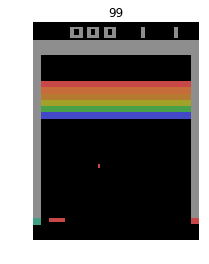

0.0

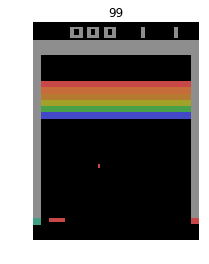

In [23]:
game.GetSummaryScore(player, max_screens=100, visualizate=True)

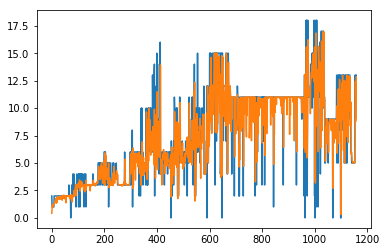

Epoch 1157; Time = 89457; avg_rewards = 12.835616438356164; Current test reward = 13.0

In [ ]:
#Обучаем стратегию
reload(breakout)
result_network = CreateNewNetwork()
#optimizator = EvolutionStratagy(result_network, elapsed_times=[], avg_rewards=[], test_rewards=[])
optimizator = EvolutionStratagy.Load(result_network, 'models/model_breakout-determ_es_600.dat',
                                     'models/params_model_breakout-determ_es_600.json')
optimizator.Train()

In [25]:
#Example game
reload(breakout)
breakout_vis = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
if HasModelVBN(result_network):
    ApplyVBN(result_network, breakout_vis, 777)

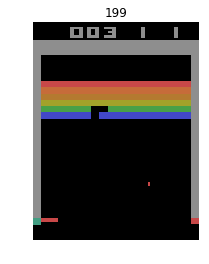

3.0

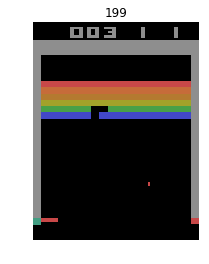

In [26]:
breakout_vis.GetSummaryScore(result_network, max_screens=300, visualizate=True)